# Time-resolved fitting with RL

Run 189245: 0.6V to 0.1V

In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


## Set up the environment

In [2]:
import rl_model
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(git_dir, 'data', '189228-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189237-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189236-time-resolved.json')

with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = True
MIXING = True

# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE, allow_mixing=MIXING)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()

Number of times: 25
0


## View the initial time and check that the initial model makes sense

Time: 1440
reward: -9.470361100490868
[-0.27628032  0.30918931  0.46417551  0.        ]


<IPython.core.display.Javascript object>


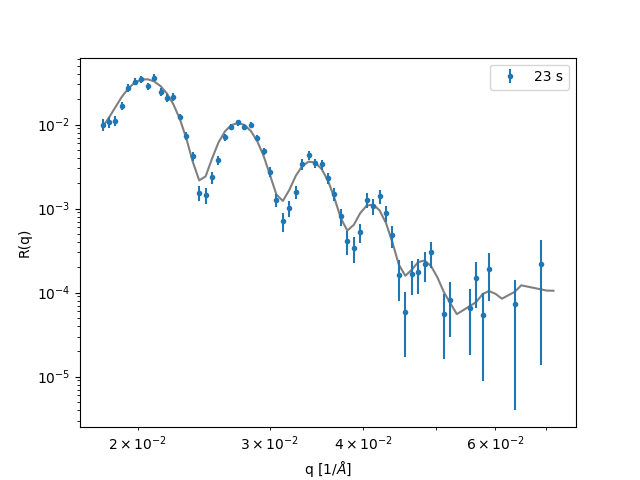

In [3]:
terminated = False
print("Time:", timestamps[env.time_stamp])

# choose a random action
if False:
    action = env.action_space.sample() 
else:
    action = env.normalized_parameters

if MIXING:
    action = list(action)
    action.append(0)
    action = np.asarray(action)

# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
# show the current position and reward
env.render(action=action, reward=reward) 
env.plot(errors=True)



## Train or load model

In [4]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-01-to-06-mixing-bck-end-free-3/",
    name_prefix="rl_model",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if False:
    model.learn(200000, callback=checkpoint_callback)
    model.save('UIUC-01-to-06-SAC-mixing-bck-end-free-2')
else:
    #model = SAC.load('UIUC-01-to-06-SAC-backward')
    #model = SAC.load('UIUC-01-to-06-SAC-mixing')
    #model = SAC.load('UIUC-01-to-06-SAC-mixing-bck')
    model = SAC.load('UIUC-01-to-06-SAC-mixing-bck-end-free-2')

KeyError: "The observation_space and action_space were not given, can't verify new environments"

## Compute uncertainties

In [5]:
deltas = env.high_array - env.low_array

samples = []
mixing = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)

    if MIXING:
        mixing.append((1+actions[:,-1]) / 2.0)


samples = np.asarray(samples).T
mixing = np.asarray(mixing).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

if MIXING:
    mixing_err = np.std(mixing, axis=1)
    print(mixing_err.shape)

(3, 25, 100)
(3, 25)
(25,)


## Run the agent on the time series data

In [6]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    chi2.append(env.chi2)
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 25
Time 1440 [1.]: -4.10952 [False] -4.10952
Time 1380 [0.9583333]: -2.09423 [False] -6.20375
Time 1320 [0.9166667]: -2.43455 [False] -8.63831
Time 1260 [0.875]: -2.66988 [False] -11.3082
Time 1200 [0.8333333]: -1.90922 [False] -13.2174
Time 1140 [0.7916667]: -2.45551 [False] -15.6729
Time 1080 [0.75]: -2.00813 [False] -17.681
Time 1020 [0.7083333]: -1.61656 [False] -19.2976
Time 960 [0.6666667]: -1.49445 [False] -20.7921
Time 900 [0.625]: -1.40766 [False] -22.1997
Time 840 [0.5833333]: -1.33502 [False] -23.5347
Time 780 [0.5416667]: -1.87712 [False] -25.4119
Time 720 [0.5]: -1.82047 [False] -27.2323
Time 660 [0.45833334]: -1.46265 [False] -28.695
Time 600 [0.41666666]: -1.38837 [False] -30.0834
Time 540 [0.375]: -2.69156 [False] -32.7749
Time 480 [0.33333334]: -1.8284 [False] -34.6033
Time 420 [0.29166666]: -1.84655 [False] -36.4499
Time 360 [0.25]: -1.8183 [False] -38.2682
Time 300 [0.20833333]: -2.67237 [False] -40.9405
Time 240 [0.16666667]: -1.53477 [False] -42.47

## Plot the results and compare to the Bayesian approach

<IPython.core.display.Javascript object>


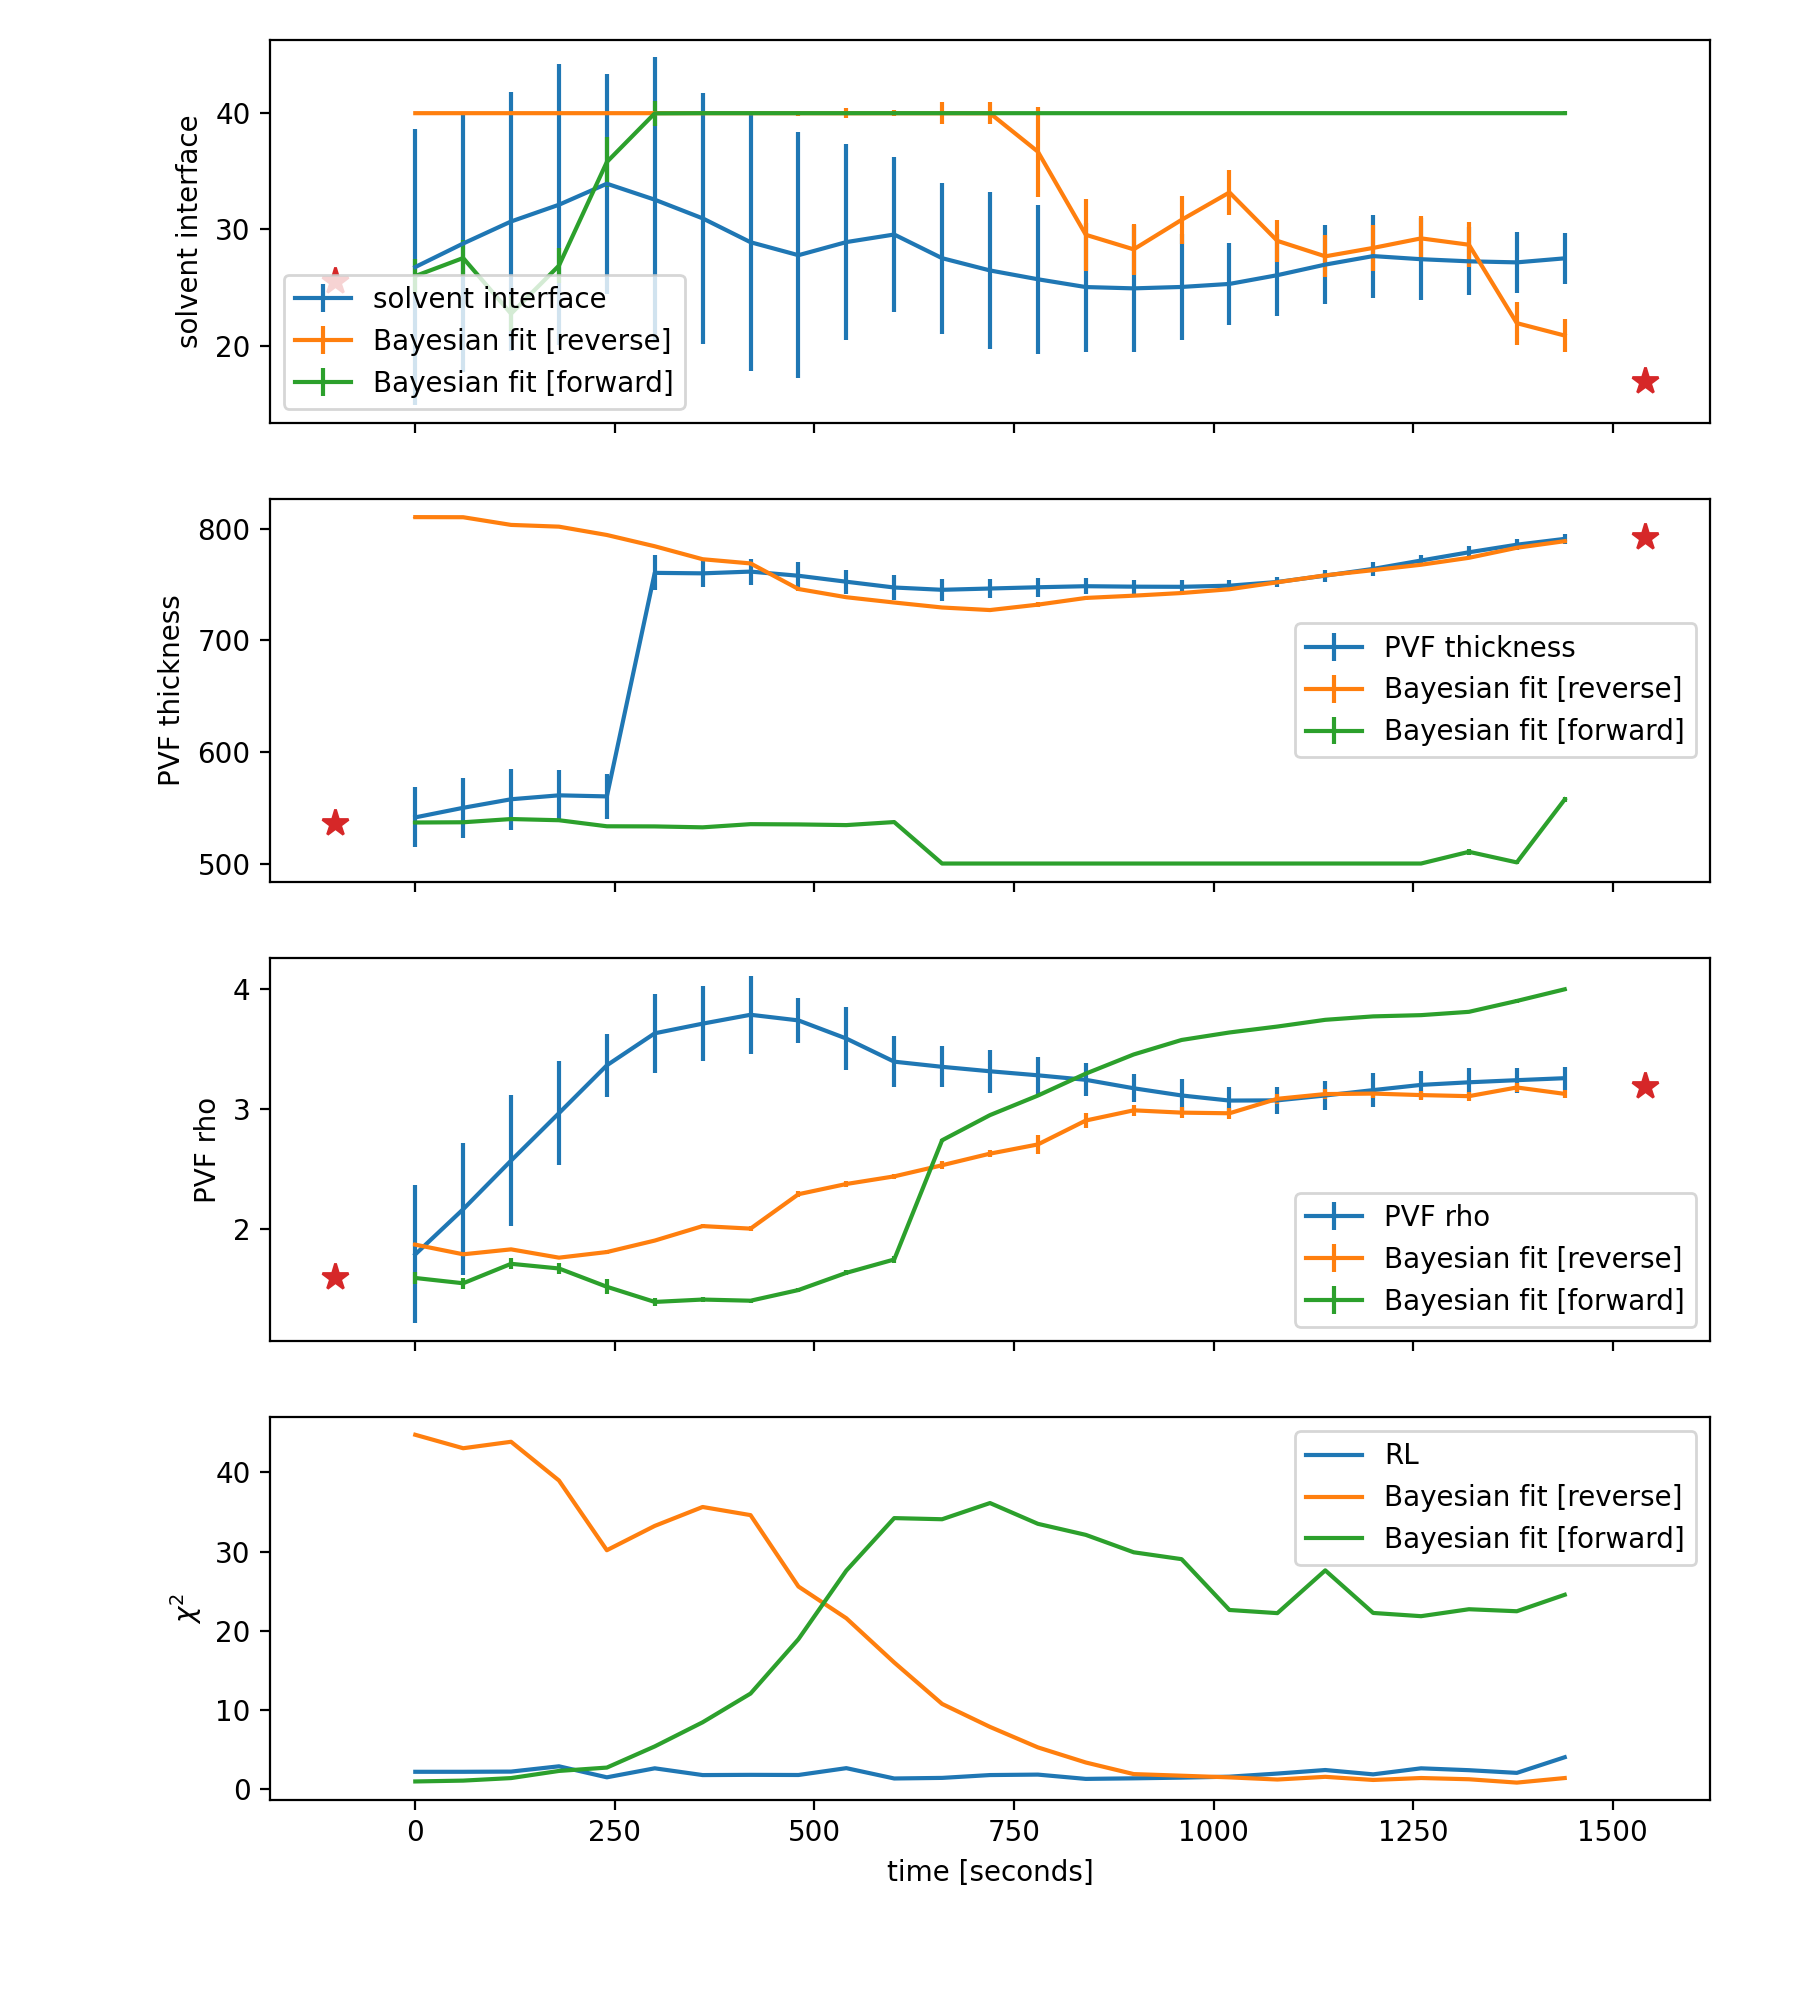

['solvent interface', 'PVF thickness', 'PVF rho']
[   0   60  120  180  240  300  360  420  480  540  600  660  720  780
  840  900  960 1020 1080 1140 1200 1260 1320 1380 1440]


Text(0.5, 0, 'time [seconds]')

In [7]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189236-bayes-forward.json')) as fd:
    bayes_fits_fwd = json.load(fd)
with open(os.path.join(git_dir, 'data', '189236-bayes-backward.json')) as fd:
    bayes_fits = json.load(fd)

t_delay = 100
if REVERSE:
    t_start = times[0]+t_delay
    t_end = -t_delay
else:
    t_end = times[-1]+t_delay
    t_start = -t_delay

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [reverse]')

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [forward]')
    
    plt.plot([t_start, t_end], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(times, chi2, label = 'RL')
print(timestamps)
plt.plot(timestamps, bayes_fits['chi2'], label = 'Bayesian fit [reverse]')
plt.plot(timestamps, bayes_fits_fwd['chi2'], label = 'Bayesian fit [forward]')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

<IPython.core.display.Javascript object>


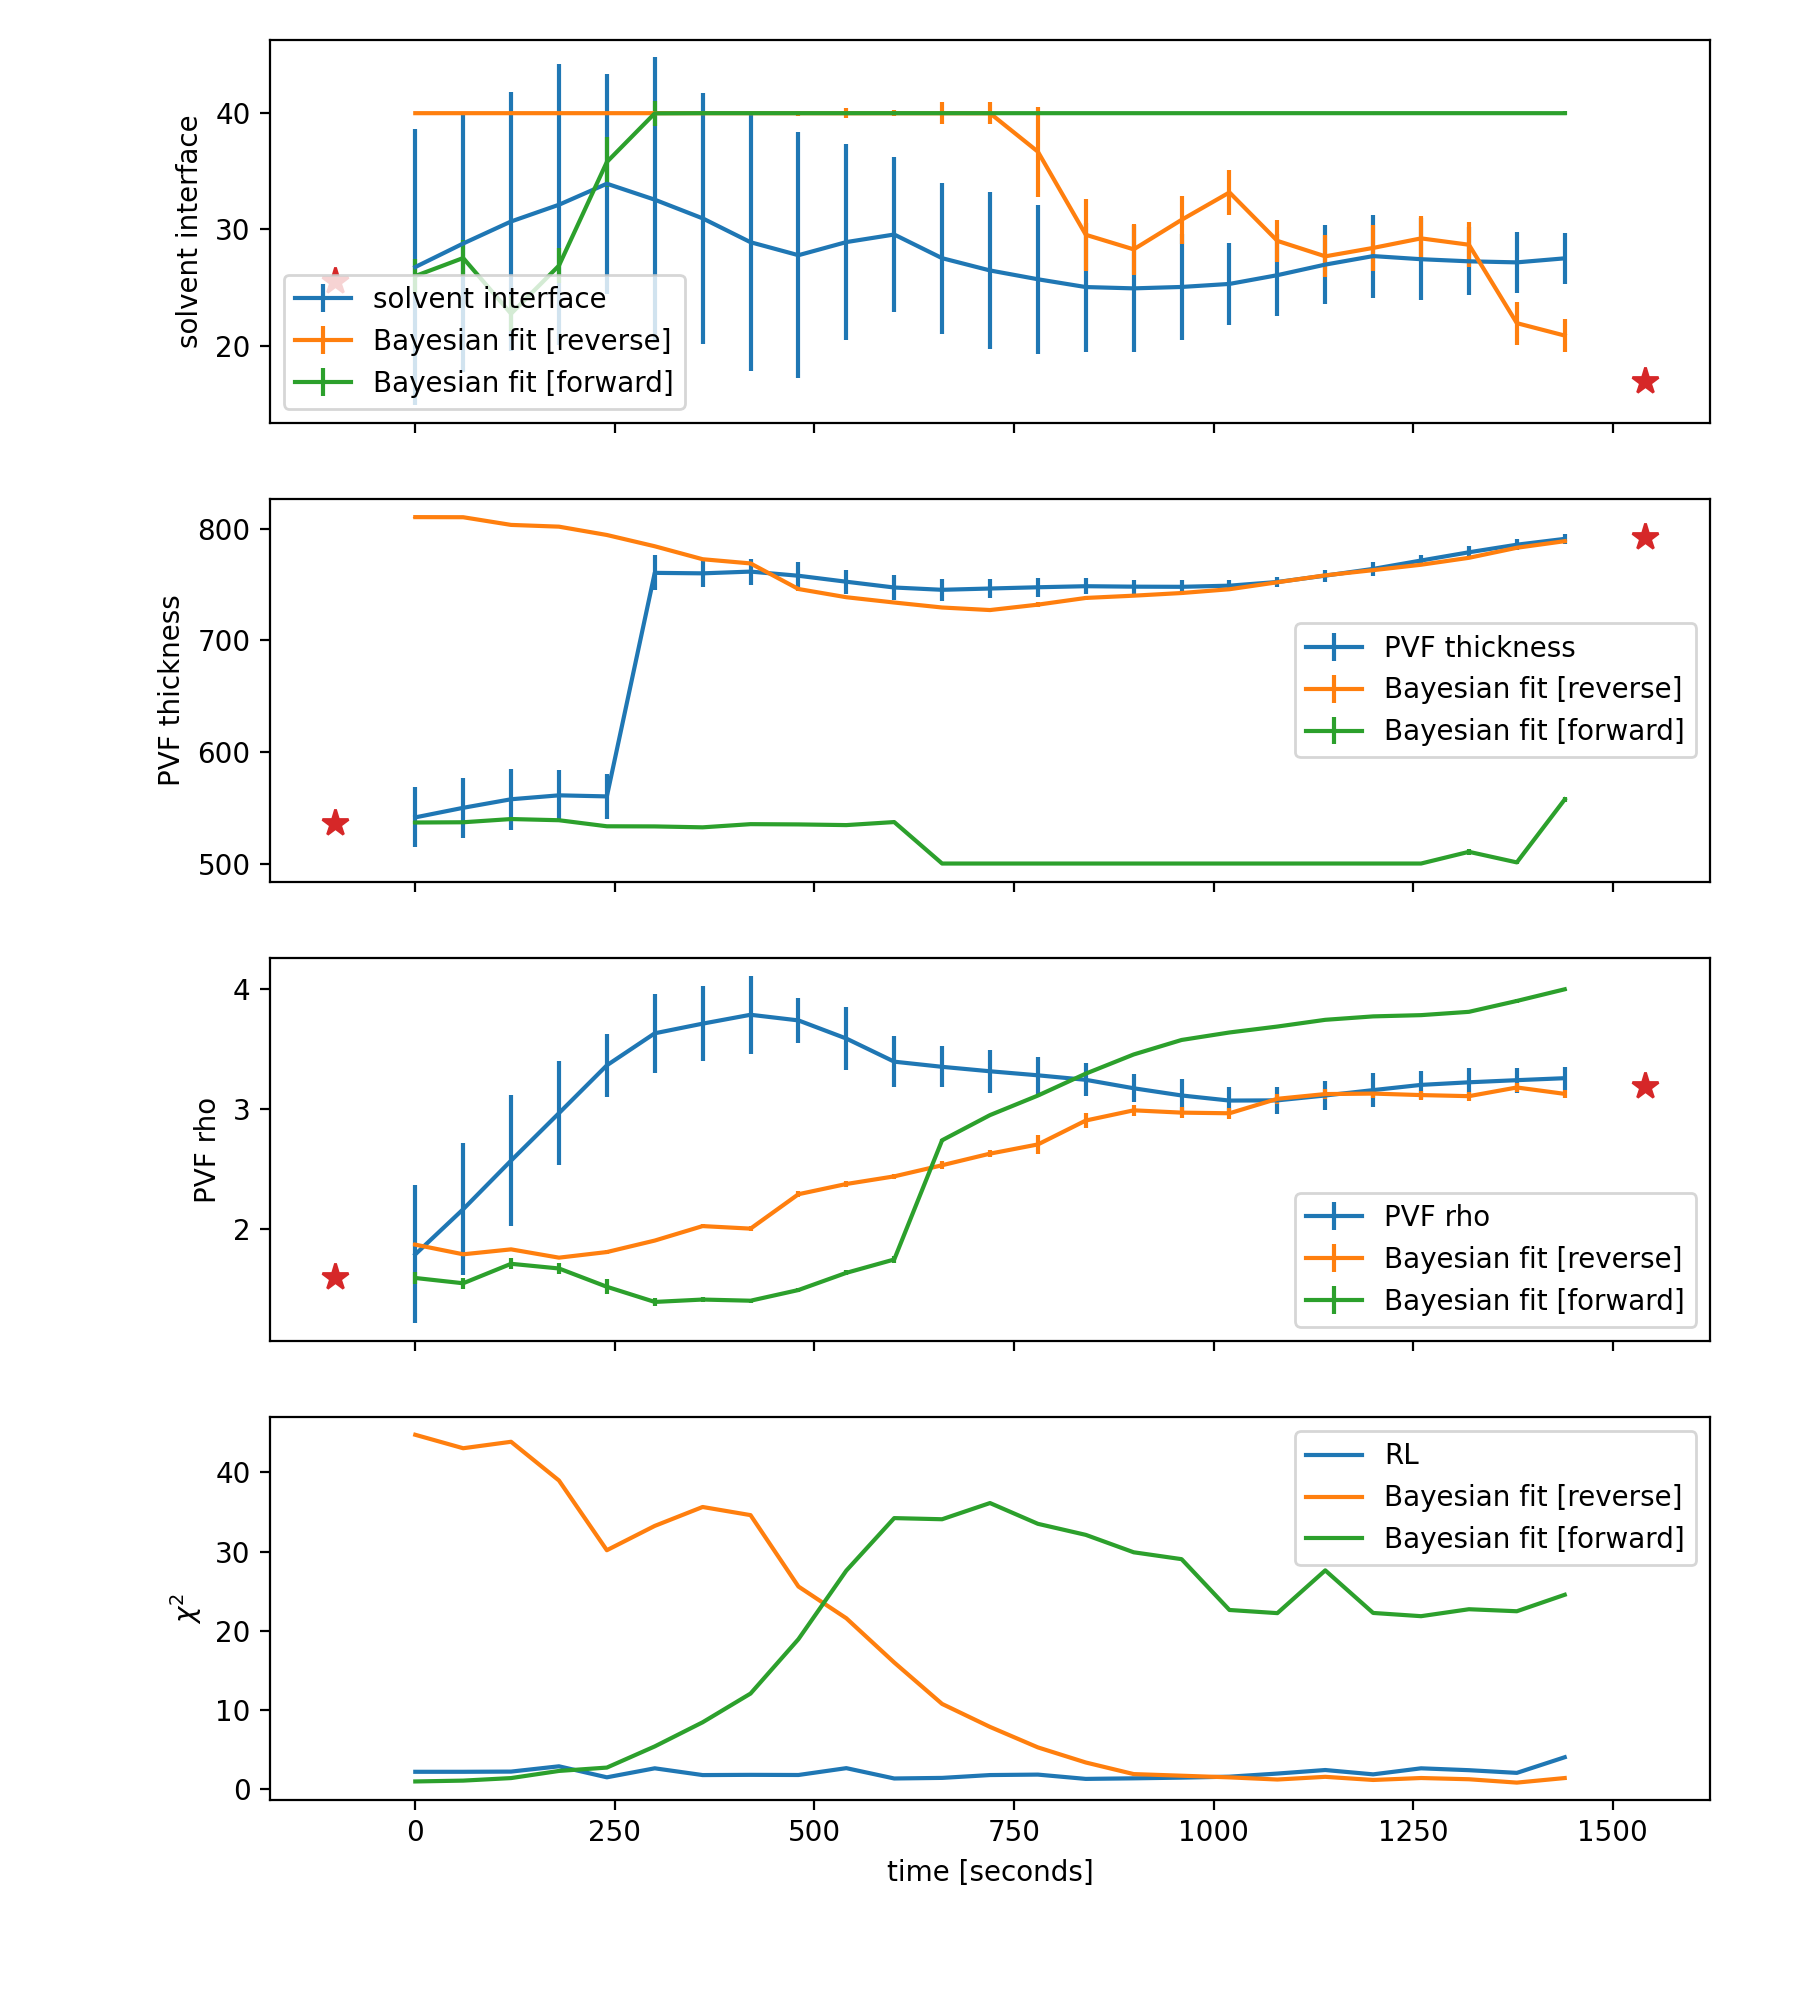

['solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'time [seconds]')

In [8]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189236-bayes-forward.json')) as fd:
    bayes_fits_fwd = json.load(fd)
with open(os.path.join(git_dir, 'data', '189236-bayes-backward.json')) as fd:
    bayes_fits = json.load(fd)


t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    fwd_times = np.flip(times)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    fwd_times = times

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [reverse]')

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [forward]')

    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(times, chi2, label = 'RL')
plt.plot(fwd_times, bayes_fits['chi2'], label = 'Bayesian fit [reverse]')
plt.plot(fwd_times, bayes_fits_fwd['chi2'], label = 'Bayesian fit [forward]')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

<IPython.core.display.Javascript object>


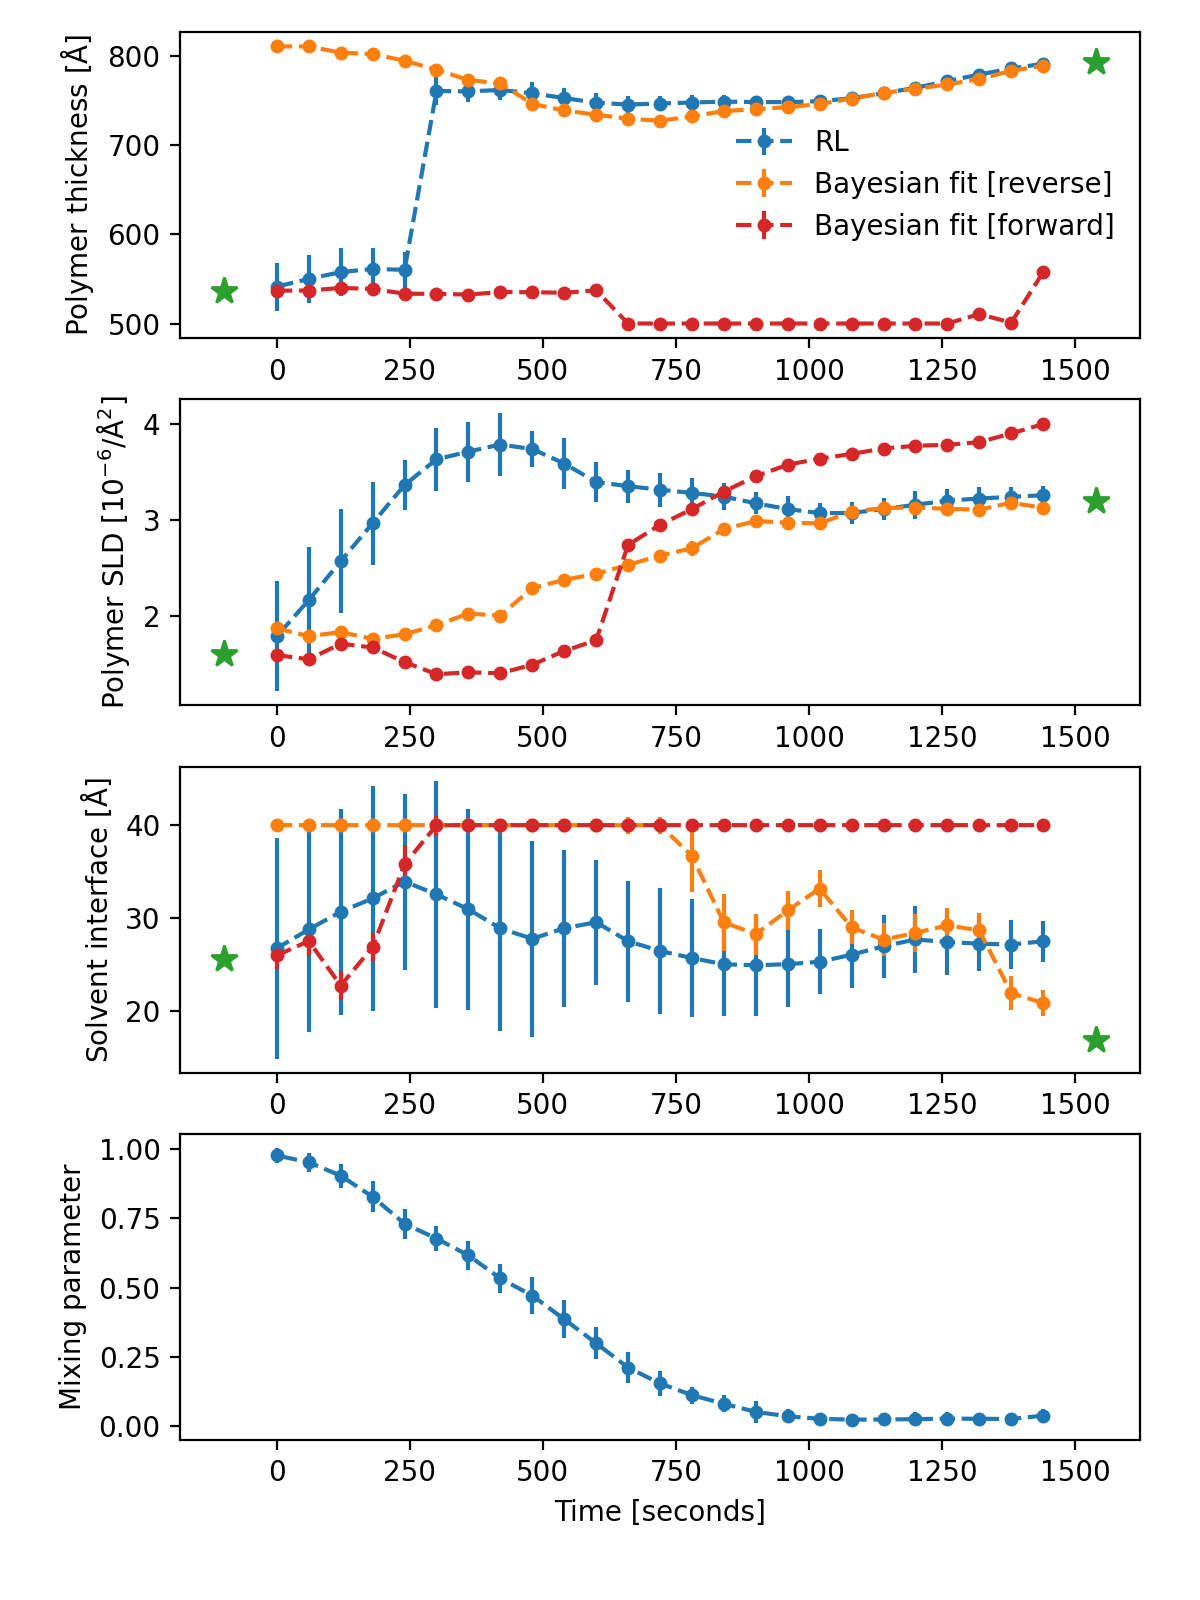

['solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'Time [seconds]')

In [9]:

fig, axs = plt.subplots(3,1, dpi=100, figsize=(6,8), sharex=False)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)

axes = ['Solvent interface [$\mathrm{\AA}$]',
        'Polymer thickness [$\mathrm{\AA}$]',
        'Polymer SLD [$10^{-6}/\mathrm{\AA}^2$]']

position = 0
for i in [1,2,0]:
    position += 1
    ax = plt.subplot(4, 1, position)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label='RL', marker='.', markersize=8, linestyle='--')

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [reverse]', marker='.', markersize=8, linestyle='--')
    
    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [forward]', marker='.', markersize=8, linestyle='--')
 
    plt.ylabel(axes[i])
    if i==1:
        plt.legend(frameon=False)


actions = np.asarray(actions)
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
mixing = (actions[:,-1] + 1)/2.0

ax = plt.subplot(4, 1, 4)

plt.errorbar(times, mixing, yerr=mixing_err, marker='.', markersize=8, linestyle='--')
plt.plot([t_initial, t_final], [1, 0], linestyle='', marker='*', markersize=10, alpha=0)
 

plt.ylabel('Mixing parameter')

plt.xlabel("Time [seconds]")

Number of times: 25


<IPython.core.display.Javascript object>


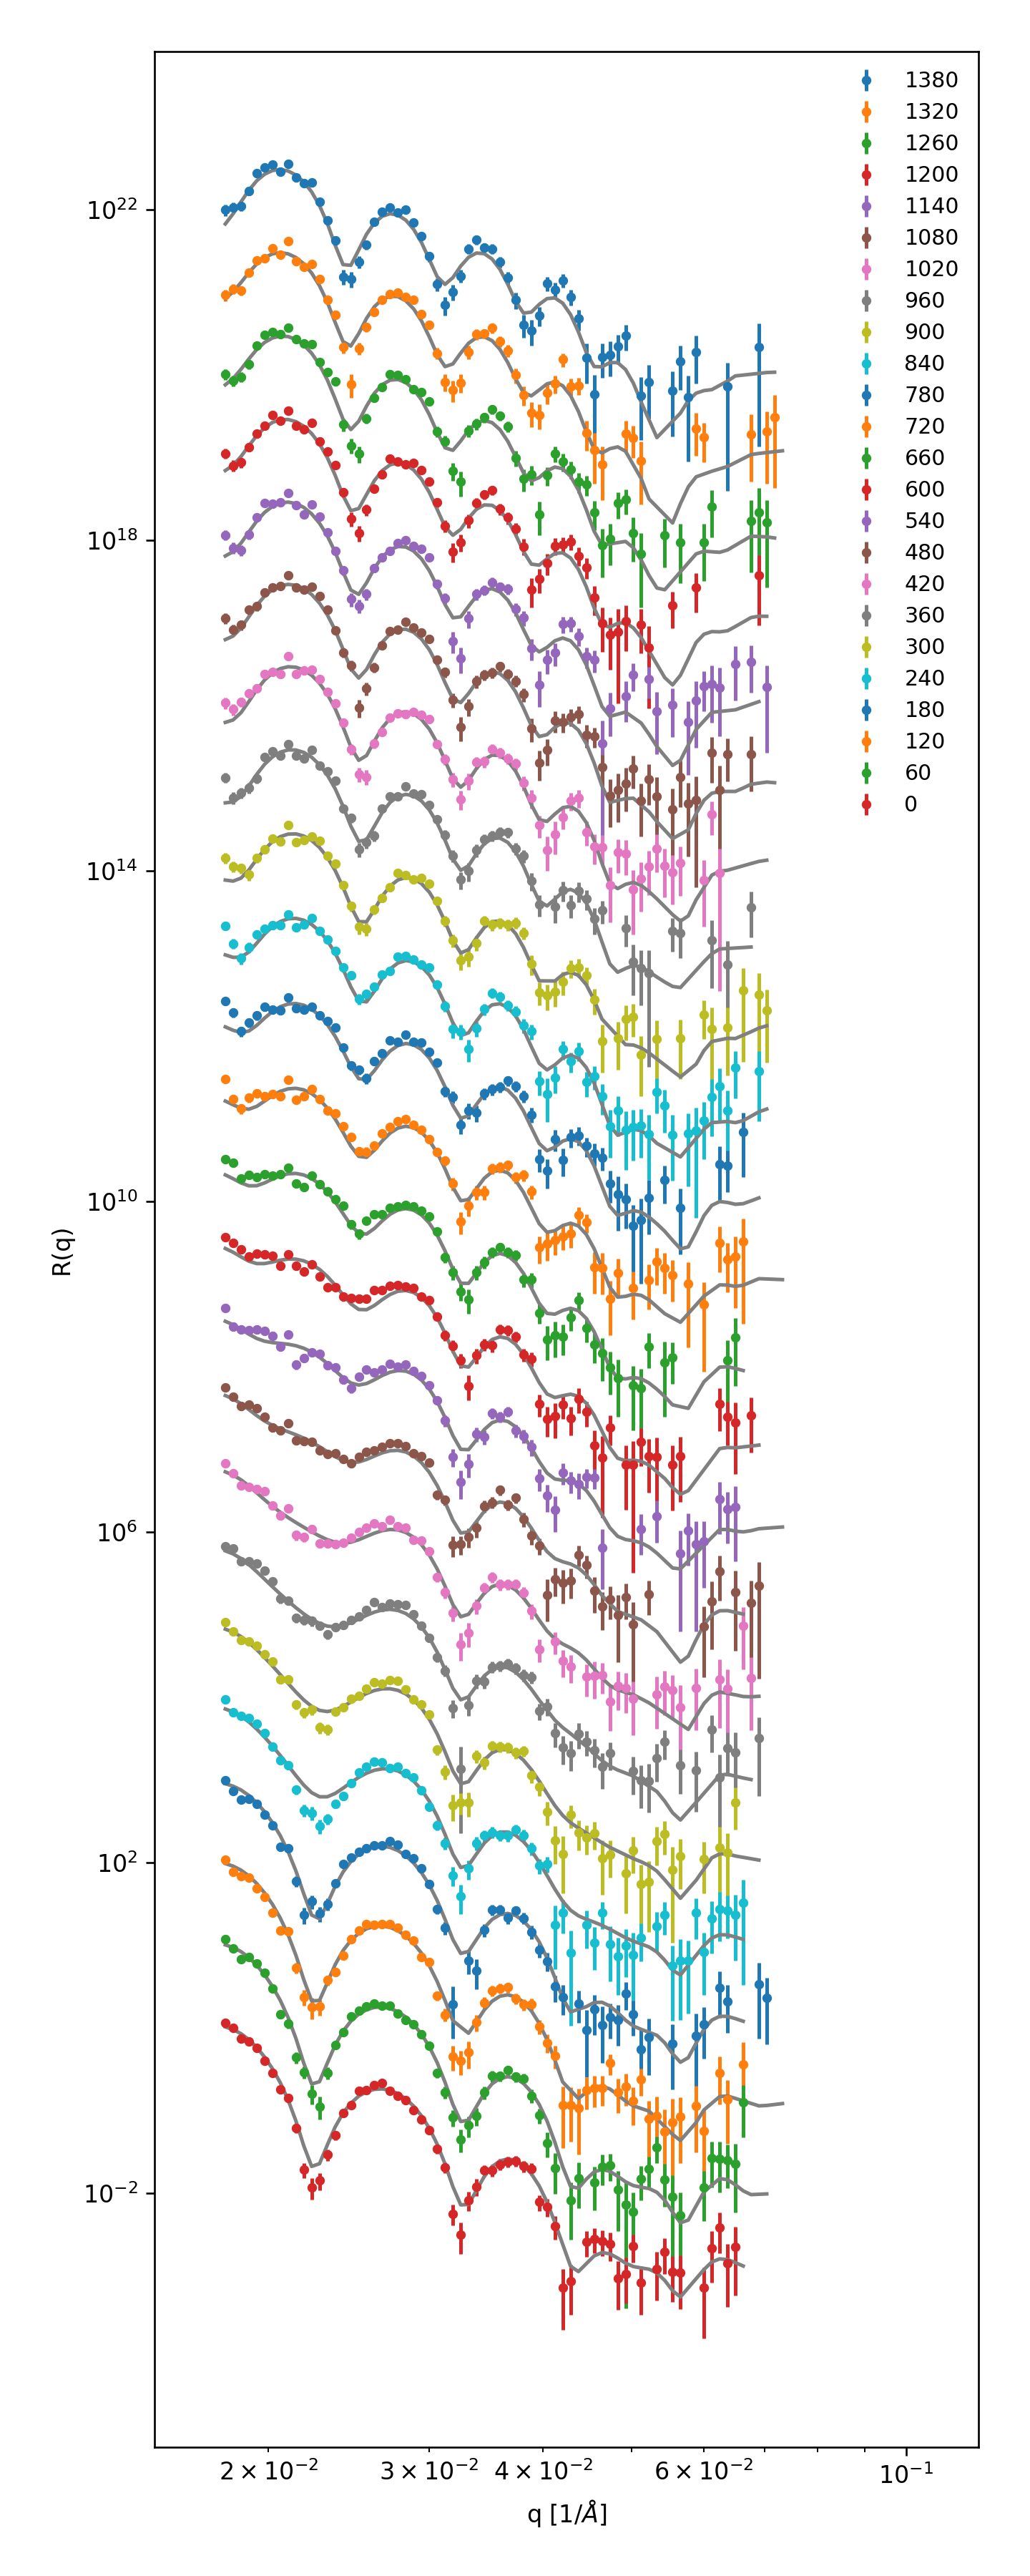

(0.015, 0.12)

In [10]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig, ax = plt.subplots(dpi=120, figsize=(6, 15))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.05)

for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.plot(scale=10.**(n_times-i), newfig=False, errors=True, label=times[i])

#handles, labels = ax.get_legend_handles_labels()
#plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 9}, loc='upper right')
plt.legend(frameon=False, prop={'size': 9}, loc='upper right')
plt.xlim([0.015, 0.12])


<IPython.core.display.Javascript object>


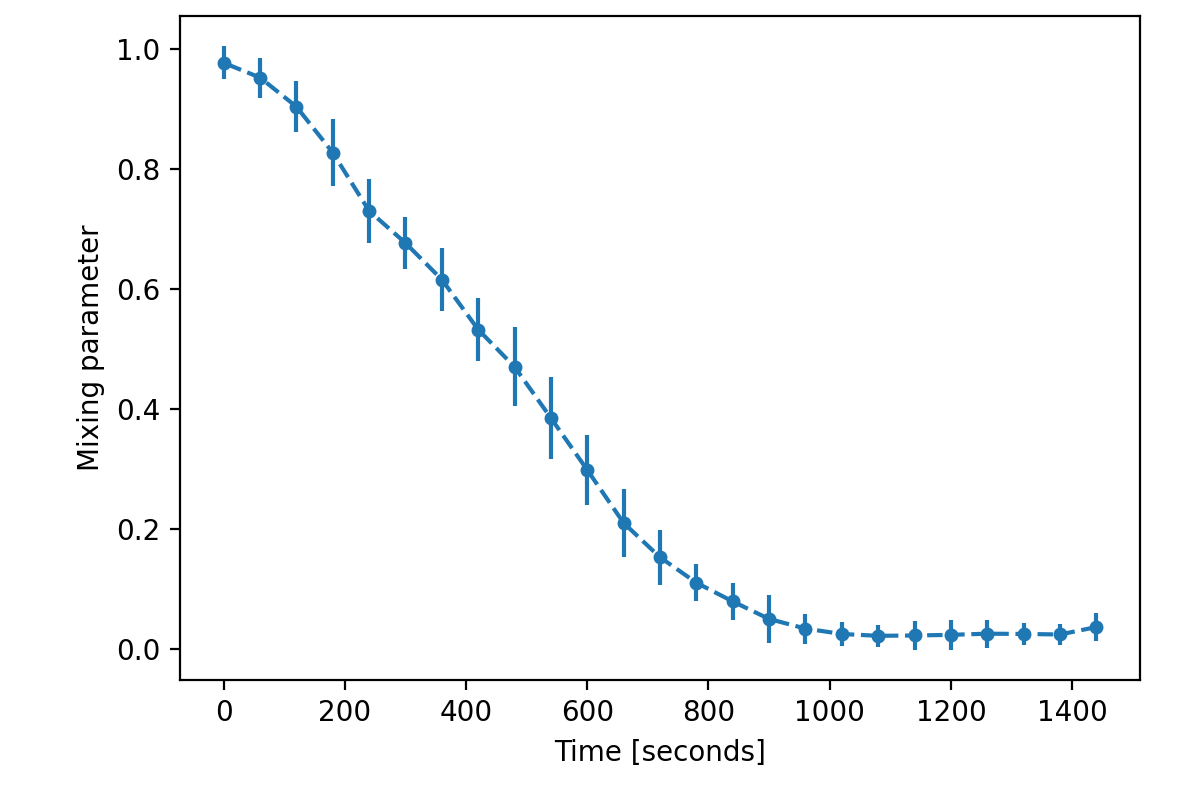

In [11]:
actions = np.asarray(actions)
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0


mixing = (actions[:,-1] + 1)/2.0


fig = plt.subplots(dpi=100, figsize=(6, 4))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.15)

plt.errorbar(times, mixing, yerr=mixing_err, marker='.', markersize=8, linestyle='--')
 
plt.xlabel('Time [seconds]')
plt.ylabel('Mixing parameter')
plt.show()

In [16]:
print(env.par_labels)
print()

# Add chi2

table_str = "Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) &  Interface ($\mathrm{\AA}$) & $\chi^2$ & "
table_str += "Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) & Interface ($\mathrm{\AA}$) & $\chi^2$ & "
table_str += "Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) & Interface ($\mathrm{\AA}$) & $\chi^2$ \\\\ \n\n"

# RL approach
sld_values = pars[2]
sld_err = errs[2]

thick_values = pars[1]
thick_err = errs[1]

rough_values = pars[0]
rough_err = errs[0]

# Bayesian approach backward
sld_values_b = bayes_fits['pvf_rho']
sld_err_b = bayes_fits['pvf_rho_err']

thick_values_b = bayes_fits['pvf_thickness']
thick_err_b = bayes_fits['pvf_thickness_err']

rough_values_b = bayes_fits['solvent_interface']
rough_err_b = bayes_fits['solvent_interface_err']

# Bayesian approach forward
sld_values_f = bayes_fits_fwd['pvf_rho']
sld_err_f = bayes_fits_fwd['pvf_rho_err']

thick_values_f = bayes_fits_fwd['pvf_thickness']
thick_err_f = bayes_fits_fwd['pvf_thickness_err']

rough_values_f = bayes_fits_fwd['solvent_interface']
rough_err_f = bayes_fits_fwd['solvent_interface_err']


for i in range(pars.shape[1]):  
    table_str += "$%3.0f \pm %3.0f$ & $%3.1f \pm %3.1f$ & $%3.0f \pm %3.0f$ & %1.1f & " % (
        thick_values[i], thick_err[i],
        sld_values[i], sld_err[i],
        rough_values[i], rough_err[i], chi2[i]
    )
    table_str += "$%3.0f \pm %3.0f$ & $%3.2f \pm %3.2f$ & $%3.0f \pm %3.0f$ & %1.1f &" % (
        thick_values_b[i], thick_err_b[i],
        sld_values_b[i], sld_err_b[i],
        rough_values_b[i], rough_err_b[i], bayes_fits['chi2'][i]
    )

    table_str += "$%3.0f \pm %3.0f$ & $%3.2f \pm %3.2f$ & $%3.0f \pm %3.0f$ & %1.1f \\\\ \n" % (
        thick_values_f[i], thick_err_f[i],
        sld_values_f[i], sld_err_f[i],
        rough_values_f[i], rough_err_f[i], bayes_fits_fwd['chi2'][i]
    )

print(table_str)
  

['solvent interface', 'PVF thickness', 'PVF rho']

Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) &  Interface ($\mathrm{\AA}$) & $\chi^2$ & Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) & Interface ($\mathrm{\AA}$) & $\chi^2$ & Thickness ($\mathrm{\AA}$) & SLD ($10^{-6}/\mathrm{\AA}^2$) & Interface ($\mathrm{\AA}$) & $\chi^2$ \\ 

$791 \pm   4$ & $3.3 \pm 0.1$ & $ 28 \pm   2$ & 4.1 & $810 \pm   1$ & $1.87 \pm 0.01$ & $ 40 \pm   0$ & 44.7 \\ 
$537 \pm   1$ & $1.59 \pm 0.05$ & $ 26 \pm   1$ & 1.0 \\ 
$786 \pm   5$ & $3.2 \pm 0.1$ & $ 27 \pm   3$ & 2.1 & $810 \pm   1$ & $1.79 \pm 0.01$ & $ 40 \pm   0$ & 43.0 \\ 
$537 \pm   1$ & $1.55 \pm 0.05$ & $ 28 \pm   2$ & 1.1 \\ 
$779 \pm   6$ & $3.2 \pm 0.1$ & $ 27 \pm   3$ & 2.4 & $803 \pm   1$ & $1.83 \pm 0.01$ & $ 40 \pm   0$ & 43.9 \\ 
$540 \pm   1$ & $1.71 \pm 0.05$ & $ 23 \pm   2$ & 1.4 \\ 
$772 \pm   5$ & $3.2 \pm 0.1$ & $ 27 \pm   4$ & 2.7 & $802 \pm   1$ & $1.76 \pm 0.01$ & $ 40 \pm   0$ & 39.0 \\ 
$539 \pm   1$